In [ ]:
import numpy as np      
import pandas as pd       
import re
import matplotlib.pyplot as plt   
import seaborn as sns

In [ ]:
%%time
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd /content/Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
%cd ../

In [ ]:
train = pd.read_csv("/content/drive/My Drive/dacon/news_train.csv") # train.csv 불러오기
test = pd.read_csv("/content/drive/My Drive/dacon/news_test.csv") # test.csv 불러오기

print(test.shape)
print(train.shape)


(142565, 6)
(118745, 6)


In [ ]:
from tqdm import tqdm
import re

def preprocess(text):
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
    #remove some puncts (except . ! ?)
    text=re.sub(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '',text)
    text=" ".join(text.split())
    return text

train['clean_text'] = train['content'].apply(preprocess)
test['clean_text'] = test['content'].apply(preprocess)
train['clean_title'] = train['title'].apply(preprocess)
test['clean_title'] = test['title'].apply(preprocess)
train["id"] = train["n_id"].astype(str) + '_' + train["ord"].astype(str)
train.drop(['n_id', 'ord', 'title', 'content'],axis = 1) 

In [ ]:
from konlpy.tag import Mecab

mecab = Mecab()
combine = [train, test]
p = ["NNG", "NNP", "VV", "VA", "MAG"]
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

def tokenizer(data, pos=p, stopword=stopwords):
  tokened = mecab.pos(data)
  return [word for word, tag in tokened if tag in pos and word not in stopword]

train['text_tokenized'] = train['clean_text'].apply(tokenizer)
test['text_tokenized'] = test['clean_text'].apply(tokenizer)
train['title_tokenized'] = train['clean_title'].apply(tokenizer)
test['title_tokenized'] = test['clean_title'].apply(tokenizer)


In [ ]:
from keras.preprocessing.text import Tokenizer

t1 = train['text_tokenized'].tolist() 
t2 = test['text_tokenized'].tolist() 
t3 = train['title_tokenized'].tolist() 
t4 = test['title_tokenized'].tolist() 

max_words = 35000
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(t1+t2+t3+t4)
train_body_token = tokenizer.texts_to_sequences(t1)
test_body_token = tokenizer.texts_to_sequences(t2)
train_head_token = tokenizer.texts_to_sequences(t3)
test_head_token = tokenizer.texts_to_sequences(t4)

In [ ]:
from keras.utils import np_utils
import numpy as np

y_train = []

for i in range(len(train['info'])):
  if train['info'].iloc[i] == 1:
    y_train.append([0, 1])
  elif train['info'].iloc[i] == 0:
    y_train.append([1, 0])

y_train = np.array(y_train)


In [ ]:
from keras.layers import Embedding, Dense, LSTM, Dropout,Bidirectional
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers    


In [ ]:
#padding with fine-tuned max len
max_len = 120

X_train = pad_sequences(train_body_token, maxlen=max_len)
X_test = pad_sequences(test_body_token, maxlen=max_len)

In [ ]:
#modelling with bi-ltsm
model3 = Sequential()
model3.add(Embedding(max_words, 100))
model3.add(Bidirectional(LSTM(128,dropout=0.2, recurrent_dropout=0.2)))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(2, activation='sigmoid'))
adam = optimizers.Adam(lr=0.003, amsgrad = True)

model3.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history3 = model3.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.1)


Epoch 1/2
3340/3340 [==============================] - 2299s 688ms/step - loss: 0.1248 - accuracy: 0.9571 - val_loss: 0.0366 - val_accuracy: 0.9869
Epoch 2/2
3340/3340 [==============================] - 2290s 686ms/step - loss: 0.0443 - accuracy: 0.9853 - val_loss: 0.0671 - val_accuracy: 0.9667


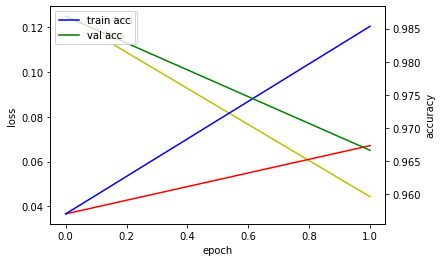

In [ ]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history3.history['loss'], 'y', label='train loss')
loss_ax.plot(history3.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history3.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history3.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()


In [ ]:
model3.save("/content/drive/My Drive/dacon/12_18.h5")

In [ ]:
mypredict = model3.predict(X_test)
my_result= [1 if i[1] >= 0.5 else 0 for i in mypredict]

submission = pd.read_csv('/content/drive/My Drive/dacon/sample_submission.csv', index_col= 'id')
submission['info'] = my_result
submission.to_csv("/content/drive/My Drive/dacon/biltsm_overboost.csv")